In [1]:
from collections import Counter
from qiskit.converters import circuit_to_dag

def circuit_report(qc):
    ops = qc.count_ops()
    n_2q_by_arity = sum(1 for inst, qargs, cargs in qc.data if inst.num_qubits == 2)
    
    dag = circuit_to_dag(qc)
    n_active = qc.num_qubits - len(list(dag.idle_wires()))

    return {
        "num_qubits": qc.num_qubits,
        "num_of_used_qubits": n_active,
        "depth": qc.depth(),
        "size": qc.size(),
        "ops_by_name": dict(ops),
        "two_qubit_ops_by_arity": n_2q_by_arity,
        "swap_count": ops.get("swap", 0),
        "measure_count": ops.get("measure", 0),
        "reset_count": ops.get("reset", 0),
        "delay_count": ops.get("delay", 0),
    }


In [2]:
sat_formula = [[1],[-2]]
#sat_formula = [[1,2],[-1,2],[-1,-2]]
#sat_formula = [[1,2,3],[-1,-2],[-3]]
#sat_formula = [[1,2],[-1,-2]]
#sat_formula = [[1,2,3]]
print(sat_formula)

formula_string = ''
for i in sat_formula:
    formula_string = formula_string + '('
    for j in i:
        if(j<0):
            formula_string = formula_string + '-'
            j = j*-1
        formula_string = formula_string + 'x_' + str(j) + ' OR '
    formula_string = formula_string[:-4] + ') AND '
formula_string = formula_string[:-5]
print('Formula:',formula_string)

num_of_clauses = len(sat_formula)
num_of_variables = 0
for clause in sat_formula:
    for i in clause:
        if abs(i) > num_of_variables:
            num_of_variables = abs(i)

print('number of clauses:',num_of_clauses)
print('number of variables:',num_of_variables)

[[1], [-2]]
Formula: (x_1) AND (-x_2)
number of clauses: 2
number of variables: 2


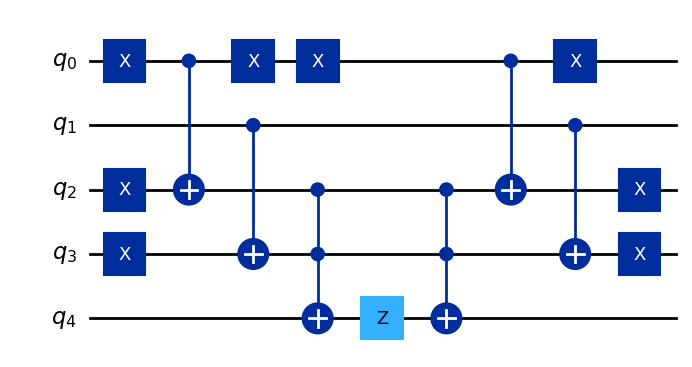

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

from math import pi

oracle = QuantumCircuit(num_of_variables + num_of_clauses + 1)

#for clause_num in range(num_of_clauses):
#    oracle.x(num_of_variables+clause_num)
#oracle.barrier()

for clause_num in range(num_of_clauses):
    clause = sat_formula[clause_num]
    control_states = []
    for i in clause:
        control_states.append(abs(i)-1)
        if(i > 0):
            oracle.x(i-1)
    oracle.x(num_of_variables+clause_num)
    oracle.mcx(control_states, num_of_variables+clause_num)
    for i in clause:
        if(i > 0):
            oracle.x(i-1)
    #oracle.barrier()
    
control_states = []
for i in range(num_of_variables,num_of_variables+num_of_clauses):
    control_states.append(i)
oracle.mcx(control_states, num_of_variables + num_of_clauses)
oracle.z(num_of_variables + num_of_clauses)
oracle.mcx(control_states, num_of_variables + num_of_clauses)
#oracle.barrier()

for clause_num in range(num_of_clauses):
    clause = sat_formula[clause_num]
    control_states = []
    for i in clause:
        control_states.append(abs(i)-1)
        if(i > 0):
            oracle.x(i-1)
    oracle.mcx(control_states, num_of_variables+clause_num)
    oracle.x(num_of_variables+clause_num)
    for i in clause:
        if(i > 0):
            oracle.x(i-1)
    #oracle.barrier()
    
#for clause_num in range(num_of_clauses):
#    oracle.x(num_of_variables+clause_num)
#oracle.barrier()

#oracle.measure(range(num_of_variables + num_of_clauses + 1),range(num_of_variables + num_of_clauses + 1))

#job = execute(oracle,Aer.get_backend('qasm_simulator'),shots=10000)
#counts = job.result().get_counts(oracle)
#print(counts)
            
oracle.draw(output='mpl')

Formula: (x_1) AND (-x_2)
Solutions:
x_1 = 1, x_2 = 0 - with probability 100.0%
{'01': 10000}


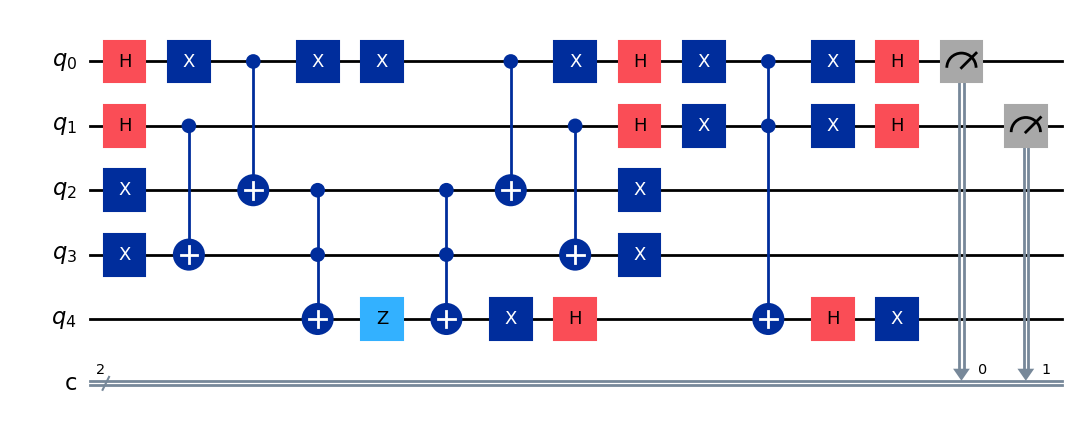

In [4]:
number_of_iterations = 1

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from math import pi

grover = QuantumCircuit(num_of_variables + num_of_clauses + 1, num_of_variables)

for i in range(num_of_variables):
    grover.h(i)
#grover.barrier()

for i in range(number_of_iterations):
    grover = grover.compose(oracle)
    
    for j in range(num_of_variables):
        grover.h(j)
    grover.x(num_of_variables + num_of_clauses)
    for j in range(num_of_variables):
        grover.x(j)
    grover.h(num_of_variables + num_of_clauses)
    control_states = []
    for j in range(num_of_variables):
        control_states.append(j)
    grover.mcx(control_states, num_of_variables + num_of_clauses)
    for j in range(num_of_variables):
        grover.x(j)
    grover.h(num_of_variables + num_of_clauses)
    for j in range(num_of_variables):
        grover.h(j)
    grover.x(num_of_variables + num_of_clauses)
    #grover.barrier()

grover.measure(range(num_of_variables),range(num_of_variables))

job = AerSimulator().run(grover,shots=10000)
counts = job.result().get_counts(grover)

print('Formula:',formula_string)
print('Solutions:')
for i in counts:
    result_to_print = ''
    for j in range(num_of_variables):
        result_to_print = result_to_print + 'x_' + str(j+1) + ' = ' + i[len(i)-j-1] + ', '
    result_to_print = result_to_print[:-2] + ' - with probability ' + str(counts[i]/100) + '%'
    print(result_to_print)
print(counts)
grover.draw(output='mpl', fold=50)

In [5]:
import os
from qiskit import transpile
from iqm.qiskit_iqm import IQMProvider

os.environ["IQM_TOKEN"] = "TOKEN"

RESONANCE_URL = "https://resonance.meetiqm.com"

def get_backend(device: str, calibration_set_id=None, use_metrics=True):
    provider = IQMProvider(
        RESONANCE_URL,
        quantum_computer=device#,      # "garnet", "emerald", "sirius"
    )
    return provider.get_backend(
        calibration_set_id=calibration_set_id,
        use_metrics=use_metrics,
    )

backend_sirius  = get_backend("sirius")

C:\Users\user\anaconda3\envs\iqm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repeated observations: using metrics.irb.circuit.move_ncz_move.QB1__COMPR1__QB2.fidelity:n_interleaved_gates=0, ignoring metrics.irb.circuit.move_ncz_move.QB1__COMPR1__QB2.fidelity:n_interleaved_gates=1
Repeated observations: using metrics.irb.circuit.move_ncz_move.QB2__COMPR1__QB5.fidelity:n_interleaved_gates=0, ignoring metrics.irb.circuit.move_ncz_move.QB2__COMPR1__QB5.fidelity:n_interleaved_gates=1
Repeated observations: using metrics.rb.clifford.xy.QB15.fidelity, ignoring metrics.rb.clifford.xy.QB15.fidelity:par=d1
Repeated observations: using metrics.rb.clifford.xy.QB17.fidelity, ignoring metrics.rb.clifford.xy.QB17.fidelity:par=d1
Repeated observations: using metrics.irb.circuit.move_ncz_move.QB3__COMPR1__QB2.fidelity:n_int

<h3>optimization_level = 3</h3>

In [6]:
transpiled = transpile(grover, backend=backend_sirius, optimization_level=3)
print(circuit_report(transpiled))

{'num_qubits': 17, 'num_of_used_qubits': 6, 'depth': 59, 'size': 87, 'ops_by_name': {'move': 32, 'r': 31, 'cz': 22, 'measure': 2}, 'two_qubit_ops_by_arity': 54, 'swap_count': 0, 'measure_count': 2, 'reset_count': 0, 'delay_count': 0}


C:\Users\user\AppData\Local\Temp\ipykernel_9928\1478029584.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  n_2q_by_arity = sum(1 for inst, qargs, cargs in qc.data if inst.num_qubits == 2)


Progress in queue:   0%|                                                                         | 0/1 [00:03<?, ?it/s]


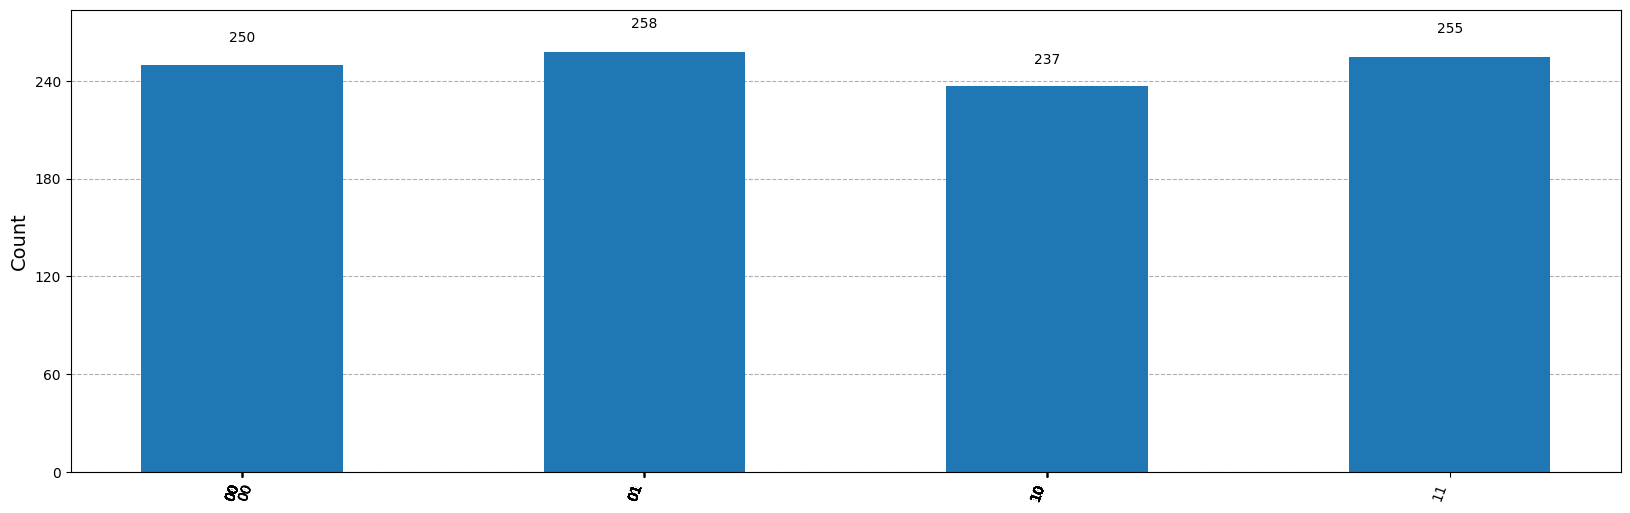

In [7]:
job = backend_sirius.run(transpiled, shots=1000)

import qiskit
if qiskit.__version__ < '1.0.0':
    # The job monitor is only compatible with qiskit versions smaller than 1.0
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)

res=job.result()
counts=res.get_counts()

#Plot the results
from qiskit.visualization import plot_histogram
import numpy as np

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()

<h3>optimization_level = 0</h3>

In [8]:
transpiled = transpile(grover, backend=backend_sirius, optimization_level=0)
print(circuit_report(transpiled))

{'num_qubits': 17, 'num_of_used_qubits': 6, 'depth': 143, 'size': 257, 'ops_by_name': {'r': 195, 'move': 38, 'cz': 22, 'measure': 2}, 'two_qubit_ops_by_arity': 60, 'swap_count': 0, 'measure_count': 2, 'reset_count': 0, 'delay_count': 0}


C:\Users\user\AppData\Local\Temp\ipykernel_9928\1478029584.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  n_2q_by_arity = sum(1 for inst, qargs, cargs in qc.data if inst.num_qubits == 2)


Progress in queue:   0%|                                                                         | 0/1 [00:03<?, ?it/s]


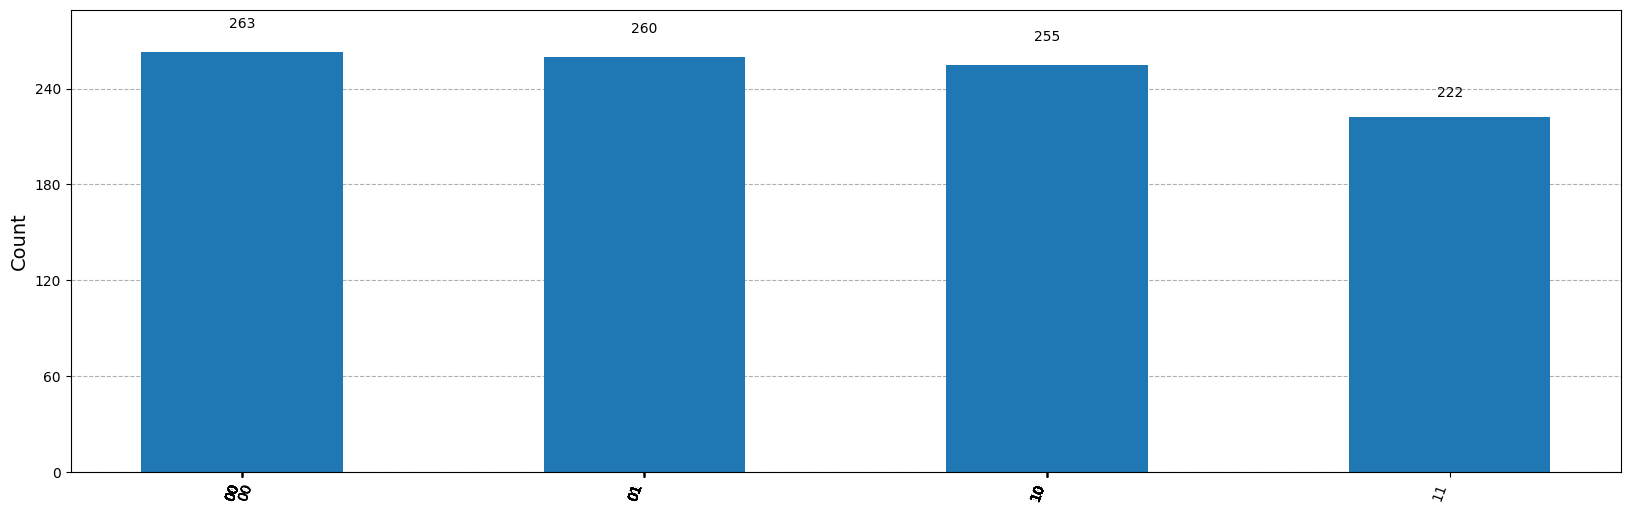

In [9]:
job = backend_sirius.run(transpiled, shots=1000)

import qiskit
if qiskit.__version__ < '1.0.0':
    # The job monitor is only compatible with qiskit versions smaller than 1.0
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)

res=job.result()
counts=res.get_counts()

#Plot the results
from qiskit.visualization import plot_histogram
import numpy as np

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()